<a href="https://colab.research.google.com/github/MasoudMoeini/Machine-Learning/blob/master/Test_with_MSE_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'content/gdrive/My Drive/Colab Notebooks'
#from google.colab import files
#files.upload()
#starting to build GANs network
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
images=np.load('/content/gdrive/My Drive/Colab Notebooks/data.npy')
resized8=np.load('/content/gdrive/My Drive/Colab Notebooks/array8.npy')
resized16=np.load('/content/gdrive/My Drive/Colab Notebooks/array16.npy')
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
print("Training set size:\t",len(images))

Training set size:	 50000


In [0]:
images=images[:500]
resized8=resized8[:500]
print(len(images))

500


In [0]:
import tensorflow.contrib.layers as lays
def generator(input,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        net = lays.conv2d_transpose(input,16, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net,32, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net, 3, [5, 5], stride=1, padding='SAME', activation_fn=tf.nn.tanh)
        return net

In [0]:
#input image (32 x 32 x 3)
def discriminator(input,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        net = lays.conv2d(input, 32, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) #16 x16 x 32
        net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) # 8 x 8 x 16
        net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME',activation_fn=tf.nn.relu) #--> 2 x 2 x 8
        dim = int(np.prod(net.get_shape()[1:]))
        fc1 = tf.reshape(net, shape=[-1, dim], name='fc1')
        w2 = tf.get_variable('w2', shape=[fc1.shape[-1], 1], dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', shape=[1], dtype=tf.float32,initializer=tf.constant_initializer(0.0))
        logits = tf.add(tf.matmul(fc1, w2), b2, name='logits')
        Dis_out = tf.nn.sigmoid(logits)
        return logits

In [0]:
tf.reset_default_graph()
Hr=tf.placeholder(tf.float32, (None,32, 32, 3))#high resolution images
Lr= tf.placeholder(tf.float32, (None,8, 8, 3))#los scale input image
Sr=generator(Lr)
HrResult=discriminator(Hr)
SrResult=discriminator(Sr,reuse=True)

In [0]:
learning_rate=0.001
d_loss = tf.reduce_mean((HrResult-SrResult)**2)   # This optimizes the discriminator.
#D_loss_summary = tf.summary.scalar(name="d_loss", tensor=d_loss)
g_loss = tf.reduce_mean((Sr-Hr)**2)#*************************************

#G_loss_summary = tf.summary.scalar(name="g_loss", tensor=g_loss)
#Do this when multiple networks interact with each other
t_vars = tf.trainable_variables() #returns all variables created(the two variable scopes) and makes trainable true
d_vars = [var for var in t_vars if 'dis' in var.name]
g_vars = [var for var in t_vars if 'gen' in var.name]

In [0]:
momentum = 0.5
gradient_descent = tf.train.MomentumOptimizer(learning_rate, momentum=momentum, use_locking=False, name='Momentum', use_nesterov=False)
#train_Dis=gradient_descent.minimize(d_loss, var_list=d_vars)
train_Dis=tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list=d_vars)
train_Gen=tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize((0.001*g_loss+d_loss),var_list=g_vars)  #(g_loss+r*s_loss) #r=0.001*****

In [0]:
batch_size=50
epochs=100
h=len(images)
init=tf.global_variables_initializer()


In [0]:
samples=[] #generator examples
with tf.Session() as sess:
    sess.run(init)
    print('number of images for training is {}'.format(h))
    for epoch in range(epochs):
        print('epoch',epoch)
        num_batches=h//batch_size #num of batches for 500 image with batch_size 50=10
        for i in range(num_batches):
            batch_images=images[i*batch_size : (i+1)*batch_size].reshape(batch_size,32,32,3)
            batch_z=resized8[i*batch_size : (i+1)*batch_size].reshape(batch_size,8,8,3)
            G=sess.run(generator(Lr,reuse=True),feed_dict={Lr:batch_z})
            #D_Hr=sess.run(discriminator(Hr,reuse=True),feed_dict={Hr:batch_images})
            #D_Sr=sess.run(discriminator(Sr,reuse=True),feed_dict={Sr:G})
            #Dloss= sess.run(d_loss, feed_dict={HrResult:D_Hr,SrResult:D_Sr})
            #Gloss=sess.run(g_loss,feed_dict={Sr:G,Hr:batch_images})
            #samples.append(G)
            Dloss, _ = sess.run([d_loss, train_Dis], feed_dict={Hr:batch_images,Sr:G})#you have to feed exactly the 
            #relevent place holder its better you neame placeholder to get to know better to feed 
            Genloss, _ = sess.run([g_loss, train_Gen], feed_dict={Lr:batch_z,Hr:batch_images})
           
            #Genloss, _ = sess.run([g_loss, train_Gen], feed_dict={Sr:G,Hr:batch_images})
        print('discrim loss: {} Gen loss: {} '.format(Dloss,Genloss))
      

number of images for training is 500
epoch 0
discrim loss: 4.289163371140603e-06 Gen loss: 0.28111886978149414 
epoch 1
discrim loss: 4.28840758104343e-06 Gen loss: 0.2811141014099121 
epoch 2
discrim loss: 4.287658157409169e-06 Gen loss: 0.2811093330383301 
epoch 3
discrim loss: 4.286909188522259e-06 Gen loss: 0.28110453486442566 
epoch 4
discrim loss: 4.2861606743827e-06 Gen loss: 0.28109976649284363 
epoch 5
discrim loss: 4.285406248527579e-06 Gen loss: 0.2810949683189392 
epoch 6
discrim loss: 4.284653641661862e-06 Gen loss: 0.2810901999473572 
epoch 7
discrim loss: 4.283902853785548e-06 Gen loss: 0.28108540177345276 
epoch 8
discrim loss: 4.283154339645989e-06 Gen loss: 0.2810806334018707 
epoch 9
discrim loss: 4.282403097022325e-06 Gen loss: 0.2810758650302887 
epoch 10
discrim loss: 4.281660494598327e-06 Gen loss: 0.2810710668563843 
epoch 11
discrim loss: 4.280919256416382e-06 Gen loss: 0.28106629848480225 
epoch 12
discrim loss: 4.280178472981788e-06 Gen loss: 0.28106153011322

KeyboardInterrupt: ignored

In [0]:
H=np.reshape(samples,(500,32,32,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

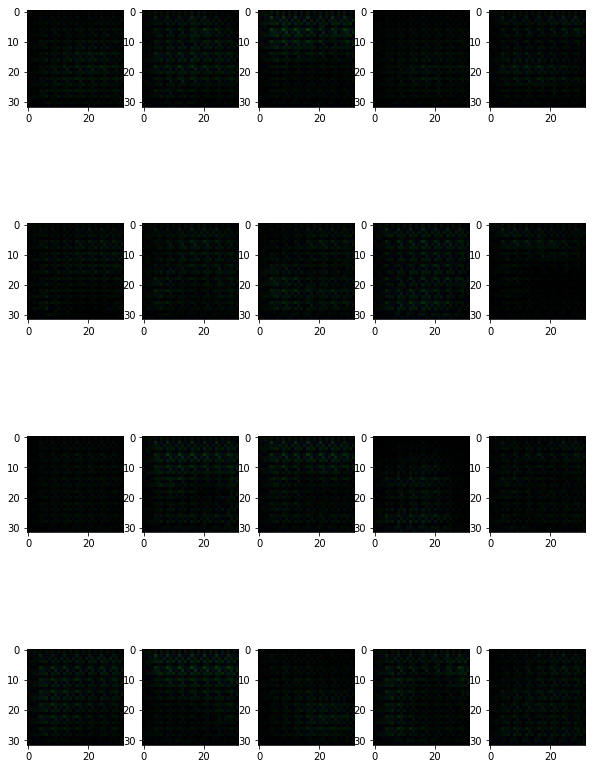

In [0]:
fig=plt.figure(figsize=(10, 15))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=H[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

In [0]:
import tensorflow as tf

a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
c = a + b

with tf.Session() as sess:
    print(c.eval(feed_dict={a:1.0,b:4.3}))

5.3
